# 第11章: 11 Model Comparison And Selection

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] この章の内容を理解できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Python基礎

⏱️ **推定学習時間**: 60-90分  
📊 **難易度**: ★★★☆☆（中級）  
🎓 **カテゴリ**: 機械学習

---


In [1]:
# ============================================================
# [コードの説明]
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    VotingClassifier, StackingClassifier
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

**生成されたデータの特徴**：
- 各サンプルは複数の特徴量を持つ
- 各サンプルには正解ラベル（クラス）が割り当てられている
- 特徴量は正規化されていない生の値

このデータを可視化すると、クラス間の分離度が確認できます。
分離が明確なほど、モデルの学習は容易になります。

## Part 1: Setup and Baseline

In [2]:
# ============================================================
# [コードの説明]
# ============================================================

# Generate data
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=12,
    n_redundant=4,
    n_classes=3,
    n_clusters_per_class=2,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {len(X_train)}, Test: {len(X_test)}")

Training: 1600, Test: 400


**生成されたデータの特徴**：
- 各サンプルは複数の特徴量を持つ
- 各サンプルには正解ラベル（クラス）が割り当てられている
- 特徴量は正規化されていない生の値

このデータを可視化すると、クラス間の分離度が確認できます。
分離が明確なほど、モデルの学習は容易になります。

## Part 2: Define Models to Compare

In [3]:
# ============================================================
# [コードの説明]
# ============================================================

# Define models with reasonable defaults
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

print(f"Comparing {len(models)} models")

Comparing 7 models


## Part 3: Cross-Validation Comparison

In [4]:
# ============================================================
# [コードの説明]
# ============================================================

# Perform cross-validation for all models
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = {}
cv_scores = {}

print("Cross-Validation Results (10-fold):")
print("="*60)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    cv_scores[name] = scores
    
    results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'min': scores.min(),
        'max': scores.max()
    }
    
    print(f"{name:25s}: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Sort by mean score
sorted_results = sorted(results.items(), key=lambda x: x[1]['mean'], reverse=True)

print("\nRanking:")
for rank, (name, res) in enumerate(sorted_results, 1):
    print(f"{rank}. {name}: {res['mean']:.4f}")

Cross-Validation Results (10-fold):
Logistic Regression      : 0.6494 (+/- 0.0258)
KNN                      : 0.8194 (+/- 0.0264)
Decision Tree            : 0.6519 (+/- 0.0342)
Random Forest            : 0.8150 (+/- 0.0289)
Gradient Boosting        : 0.7806 (+/- 0.0304)
SVM                      : 0.8581 (+/- 0.0237)
MLP                      : 0.8669 (+/- 0.0304)

Ranking:
1. MLP: 0.8669
2. SVM: 0.8581
3. KNN: 0.8194
4. Random Forest: 0.8150
5. Gradient Boosting: 0.7806
6. Decision Tree: 0.6519
7. Logistic Regression: 0.6494


**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

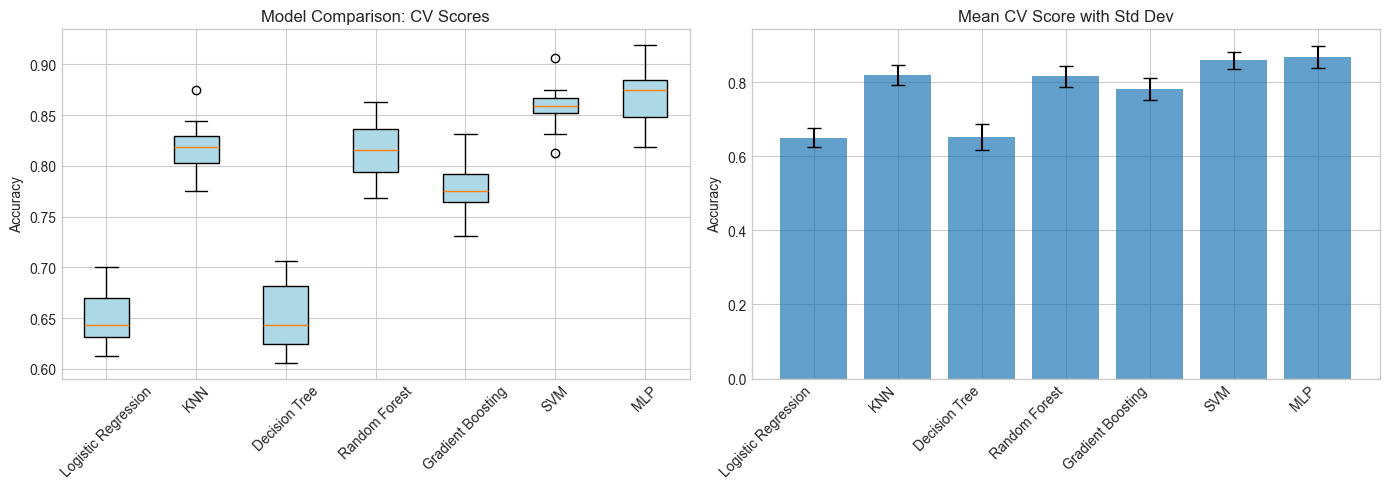

In [5]:
# Visualize CV results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
names = list(cv_scores.keys())
scores_list = [cv_scores[name] for name in names]

bp = axes[0].boxplot(scores_list, labels=names, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Comparison: CV Scores')
axes[0].tick_params(axis='x', rotation=45)

# Bar plot with error bars
means = [results[name]['mean'] for name in names]
stds = [results[name]['std'] for name in names]

x_pos = np.arange(len(names))
axes[1].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(names, rotation=45, ha='right')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Mean CV Score with Std Dev')

plt.tight_layout()
plt.show()

**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

## Part 4: Statistical Significance Testing

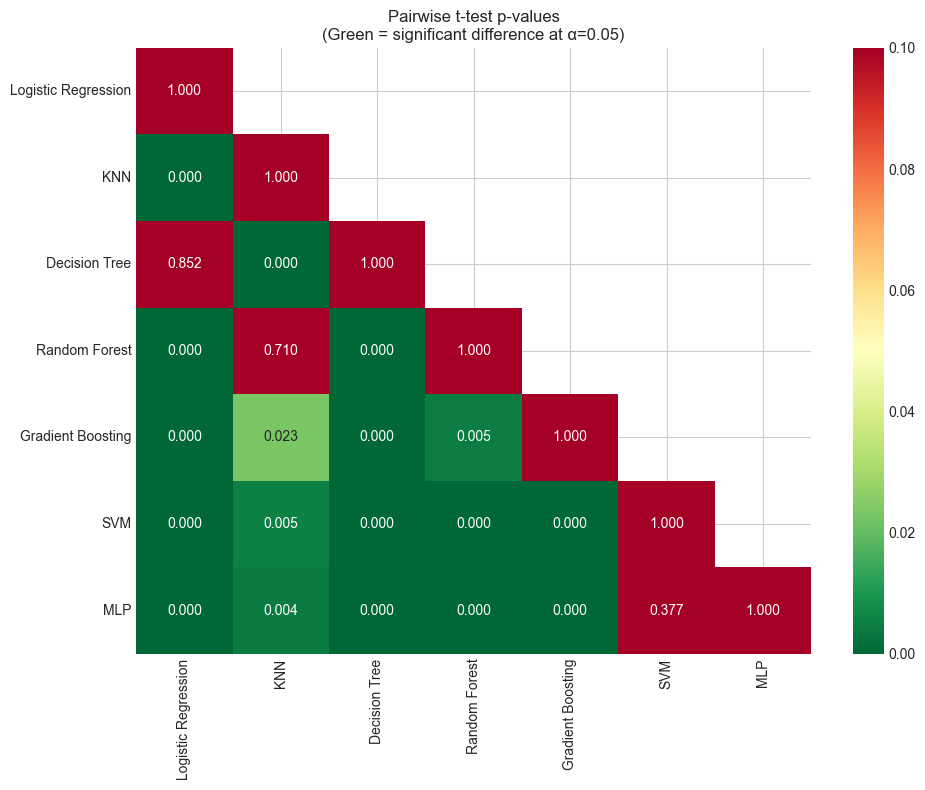

p < 0.05: Statistically significant difference


In [6]:
# Pairwise t-tests between models
model_names = list(cv_scores.keys())
n_models = len(model_names)

# Create p-value matrix
p_values = np.ones((n_models, n_models))

for i in range(n_models):
    for j in range(i+1, n_models):
        # Paired t-test
        t_stat, p_value = stats.ttest_rel(cv_scores[model_names[i]], 
                                          cv_scores[model_names[j]])
        p_values[i, j] = p_value
        p_values[j, i] = p_value

# Visualize
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(p_values, dtype=bool), k=1)
sns.heatmap(p_values, annot=True, fmt='.3f', cmap='RdYlGn_r',
            xticklabels=model_names, yticklabels=model_names,
            mask=mask, vmin=0, vmax=0.1)
plt.title('Pairwise t-test p-values\n(Green = significant difference at α=0.05)')
plt.tight_layout()
plt.show()

print("p < 0.05: Statistically significant difference")

**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

## Part 5: Test Set Evaluation

In [7]:
# ============================================================
# [コードの説明]
# ============================================================

# Train all models and evaluate on test set
test_results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    
    test_results.append({
        'Model': name,
        'Train': train_score,
        'Test': test_score,
        'Overfit': train_score - test_score
    })

df_test = pd.DataFrame(test_results).sort_values('Test', ascending=False)
print("Test Set Results:")
print(df_test.to_string(index=False))

Test Set Results:
              Model    Train   Test  Overfit
                MLP 1.000000 0.8725 0.127500
                SVM 0.918750 0.8600 0.058750
      Random Forest 1.000000 0.8350 0.165000
                KNN 0.890000 0.7925 0.097500
  Gradient Boosting 0.933125 0.7825 0.150625
      Decision Tree 0.933125 0.7100 0.223125
Logistic Regression 0.668750 0.6650 0.003750


**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

## Part 6: Ensemble Methods

In [8]:
# Voting Classifier (Hard Voting)
voting_hard = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
    ],
    voting='hard'
)

# Voting Classifier (Soft Voting)
voting_soft = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
    ],
    voting='soft'
)

# Evaluate ensembles
print("Ensemble Methods:")
print("="*50)

for name, model in [('Hard Voting', voting_hard), ('Soft Voting', voting_soft)]:
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    
    print(f"\n{name}:")
    print(f"  CV Score: {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"  Test Score: {test_score:.4f}")

Ensemble Methods:

Hard Voting:
  CV Score: 0.8287 (+/- 0.0223)
  Test Score: 0.8300

Soft Voting:
  CV Score: 0.8637 (+/- 0.0199)
  Test Score: 0.8875


**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

In [9]:
# ============================================================
# [コードの説明]
# ============================================================

# Stacking Classifier
stacking = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('svm', SVC(kernel='rbf', probability=True, random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

scores = cross_val_score(stacking, X_train_scaled, y_train, cv=5)
stacking.fit(X_train_scaled, y_train)
test_score = stacking.score(X_test_scaled, y_test)

print("\nStacking Classifier:")
print(f"  CV Score: {scores.mean():.4f} (+/- {scores.std():.4f})")
print(f"  Test Score: {test_score:.4f}")


Stacking Classifier:
  CV Score: 0.8562 (+/- 0.0202)
  Test Score: 0.8700


**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

## Part 7: Final Model Selection

In [10]:
# ============================================================
# [コードの説明]
# ============================================================

# Comprehensive comparison
all_models = {
    **models,
    'Voting (Soft)': voting_soft,
    'Stacking': stacking
}

final_comparison = []

for name, model in all_models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    if not hasattr(model, 'classes_'):
        model.fit(X_train_scaled, y_train)
    
    test_score = model.score(X_test_scaled, y_test)
    
    final_comparison.append({
        'Model': name,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test': test_score
    })

df_final = pd.DataFrame(final_comparison).sort_values('Test', ascending=False)
print("Final Model Comparison:")
print(df_final.to_string(index=False))

Final Model Comparison:
              Model  CV Mean   CV Std   Test
      Voting (Soft) 0.863750 0.019922 0.8875
                MLP 0.858750 0.016226 0.8725
           Stacking 0.856250 0.020156 0.8700
                SVM 0.851875 0.023684 0.8600
      Random Forest 0.807500 0.019425 0.8350
                KNN 0.815000 0.027557 0.7925
  Gradient Boosting 0.786250 0.025510 0.7825
      Decision Tree 0.651875 0.013199 0.7100
Logistic Regression 0.648750 0.028614 0.6650


**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

In [11]:
# ============================================================
# [コードの説明]
# ============================================================

# Select best model
best_model_name = df_final.iloc[0]['Model']
best_model = all_models[best_model_name]

print(f"\nSelected Model: {best_model_name}")
print(f"Test Accuracy: {df_final.iloc[0]['Test']:.4f}")

# Final evaluation
y_pred = best_model.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Selected Model: Voting (Soft)
Test Accuracy: 0.8875

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       132
           1       0.88      0.95      0.91       135
           2       0.92      0.81      0.86       133

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



**予測結果の使い方**：
- 予測値と実際の値を比較して精度を評価
- 誤った予測のパターンを分析
- 予測確率を見て、モデルの確信度を確認

予測が完璧でないのは正常です。重要なのは、
実用に耐える精度かどうかを判断することです。

## Summary

In this notebook, you learned:

### Model Comparison
- Use cross-validation for fair comparison
- Consider both mean and variance of scores
- Statistical tests for significance

### Ensemble Methods
- **Voting**: Combine predictions (hard/soft)
- **Stacking**: Use meta-learner
- Often outperform individual models

### Selection Criteria
- Performance (accuracy, F1, etc.)
- Stability (low variance across folds)
- Overfitting (train-test gap)
- Interpretability and speed

### Next Steps
Continue to **Notebook 12** for the complete ML pipeline!

### ⚠️ よくあるエラー #1: データのスケーリング忘れ

機械学習モデル（特にニューラルネットワーク）でデータをスケーリングしないと性能が低下します。

**原因:**
1. `StandardScaler`を使わずに生データを入力
2. 訓練セットとテストセットで異なるscalerを使用

**✅ 解決法:**

```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # fit_transformではない！
```

---


### ⚠️ よくあるエラー #2: データリーク

テストセットの情報が訓練に漏れると、評価が不正確になります。

**原因:**
1. テストセットで`fit_transform`を使う
2. スケーリング前にデータ分割

**✅ 解決法:**

```python
# ✅ 正しい順序
# 1. データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y)
# 2. スケーリング（訓練セットでfit）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # transformのみ
```

---


---

## 🎓 自己評価クイズ

学習内容を確認しましょう！すぐに答えを見ずに、まず自分で考えてみてください。

### Q1: なぜ特徴量のスケーリングが重要なのですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 機械学習アルゴリズムはスケールに敏感だから

特にニューラルネットワークや距離ベースのアルゴリズム（SVM、k-NN）は、特徴量のスケールが異なると正しく学習できません。StandardScalerで平均0、標準偏差1に正規化することで、全ての特徴量を同じスケールにできます。

</details>

---

### Q2: 訓練セットとテストセットで別々にスケーリングしてはいけない理由は？

<details>
<summary>💡 答えを見る</summary>

**答え**: データリークが発生し、評価が不正確になるから

テストセットで`fit_transform`を使うと、テストセットの統計量（平均、標準偏差）を使ってスケーリングしてしまいます。これは本番環境では利用できない情報なので、評価が楽観的になります。必ず訓練セットの統計量を使って`transform`のみ行います。

</details>

---



---

## ➡️ 次のステップ

### 学習を続ける

次のノートブックへ

### 復習が必要な場合

- **Notebook 02: 前処理**
- **Notebook 03: 評価指標**

### さらに学ぶために

**書籍:**
- "Hands-On Machine Learning" by Aurélien Géron
- "Pattern Recognition and Machine Learning" by Christopher Bishop

**オンラインリソース:**
- scikit-learn documentation: https://scikit-learn.org
- Kaggle: 実データで練習
- UCI ML Repository: データセット

---

### 🎉 お疲れ様でした！

次の章でさらに深く探求しましょう！
